# Time Series Forecasting using Auto-Arima
ARIMA(Autoregressive integrated moving average) is a statistical analysis model that uses time series data to predict future values based on the fact that past values have sufficient information.

Auto-arima applies automated configuration tasks to the ARIMA model to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [3]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
from sktime.forecasting.arima import AutoARIMA
import pmdarima as pm
from sktime.utils.plotting import plot_series

In [4]:
#Read in the data
bikes_df = pd.read_excel("bikes.xlsx")
bikeshops_df = pd.read_excel("bikeshops.xlsx")
orderlines_df = pd.read_excel(io ="orderlines.xlsx",converters={'order.date':str})

In [7]:
#Join the necessary columns
joined_df = orderlines_df\
.drop(columns = "Unnamed: 0",axis=0)\
.merge(
    right = bikes_df,
    how = 'left',
    left_on = 'product.id',
    right_on = 'bike.id'
)\
.merge(
    right = bikeshops_df,
    how = 'left',
    left_on = 'customer.id',
    right_on = 'bikeshop.id'
)

joined_df.head()

,order.id,order.line,order.date,customer.id,product.id,quantity,bike.id,model,description,price,bikeshop.id,bikeshop.name,location
0,1,1,2011-01-07 00:00:00,2,48,1,48,Jekyll Carbon 2,Mountain - Over Mountain - Carbon,6070,2,Ithaca Mountain Climbers,"Ithaca, NY"
1,1,2,2011-01-07 00:00:00,2,52,1,52,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,2,Ithaca Mountain Climbers,"Ithaca, NY"
2,2,1,2011-01-10 00:00:00,10,76,1,76,Beast of the East 1,Mountain - Trail - Aluminum,2770,10,Kansas City 29ers,"Kansas City, KS"
3,2,2,2011-01-10 00:00:00,10,52,1,52,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,10,Kansas City 29ers,"Kansas City, KS"
4,3,1,2011-01-10 00:00:00,6,2,1,2,Supersix Evo Hi-Mod Team,Road - Elite Road - Carbon,10660,6,Louisville Race Equipment,"Louisville, KY"


In [8]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15644 entries, 0 to 15643
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order.id       15644 non-null  int64 
 1   order.line     15644 non-null  int64 
 2   order.date     15644 non-null  object
 3   customer.id    15644 non-null  int64 
 4   product.id     15644 non-null  int64 
 5   quantity       15644 non-null  int64 
 6   bike.id        15644 non-null  int64 
 7   model          15644 non-null  object
 8   description    15644 non-null  object
 9   price          15644 non-null  int64 
 10  bikeshop.id    15644 non-null  int64 
 11  bikeshop.name  15644 non-null  object
 12  location       15644 non-null  object
dtypes: int64(8), object(5)
memory usage: 1.7+ MB


In [9]:
#Clean the data    
df = joined_df
df['order.date'] = pd.to_datetime(df['order.date'])
    
temp_df = df['description'].str.split(" - ", expand = True)
df["category.1"] = temp_df[0]
df["category.2"] = temp_df[1]
df["frame.material"] = temp_df[2]
    
temp_df2 = df['location'].str.split(", ", expand = True)
df['city'] = temp_df[0]
df["state"] = temp_df[1]
    
df['total.price'] = df['quantity'] * df['price']
    
df.columns
    
cols_to_keep_list = [
    "order.id",
    'order.line',
    'order.date',  
    'quantity',
    'price',
    'total.price',
    'model',
    'category.1',
    'category.2',
    'frame.material',
    'bikeshop.name',
    'city',
    'state'
]
    
df = df[cols_to_keep_list]
    
df.columns = df.columns.str.replace(".","_",regex = False)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15644 entries, 0 to 15643
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        15644 non-null  int64         
 1   order_line      15644 non-null  int64         
 2   order_date      15644 non-null  datetime64[ns]
 3   quantity        15644 non-null  int64         
 4   price           15644 non-null  int64         
 5   total_price     15644 non-null  int64         
 6   model           15644 non-null  object        
 7   category_1      15644 non-null  object        
 8   category_2      15644 non-null  object        
 9   frame_material  15644 non-null  object        
 10  bikeshop_name   15644 non-null  object        
 11  city            15644 non-null  object        
 12  state           15644 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(7)
memory usage: 1.7+ MB


In [10]:
# Format the data for forecasting
bike_sales_m_df = df[['order_date', 'total_price']] \
    .set_index("order_date") \
    .resample("M", kind = "period") \
    .sum()

bike_sales_m_df.shape

(60, 1)

In [11]:
y = bike_sales_m_df['total_price']

In [12]:
#Use auto arima to determine pdq
autoModel = pm.auto_arima(y, trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(y)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1738.150, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1860.164, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1741.969, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1828.251, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1740.278, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1737.779, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1741.106, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1739.408, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1738.765, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1737.929, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1730.103, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1732.201, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1731.007, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : 

ARIMA(order=(3, 0, 0), scoring_args={}, suppress_warnings=True)

In [13]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(y)

AutoARIMA(sp=12, suppress_warnings=True)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='total_price'>)

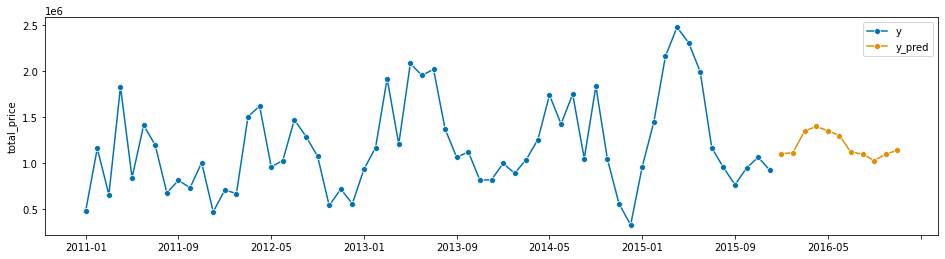

In [14]:
# Plot the forecast
y_pred = forecaster.predict(fh=np.arange(1,12))
plot_series(y,y_pred, labels=["y","y_pred"])